In [ ]:
"""
Classify a tweet as being one of the following categories:
601:
602:
603:
604:
605:
606:
607:

Currently only supports english tweets.
"""

In [161]:
import sys, os

sys.path.append(os.path.abspath(os.path.join("..", "..", "..", "src")))

import pandas as pd
import numpy as np
import matplotlib as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

from common.app import App
from common.helpers import Helpers

### Setup

In [5]:
app_run = App(debug=False)
data_path = os.path.join(app_run.root_dir, "interactive", "data")
df = pd.read_pickle(os.path.join(data_path, "db_en_detect.pkl"))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238523 entries, 0 to 238522
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tweet_id         238523 non-null  object 
 1   covid_theme      238523 non-null  int64  
 2   created_at       238523 non-null  object 
 3   handle           238523 non-null  object 
 4   name             238523 non-null  object 
 5   old_text         152734 non-null  object 
 6   text             237543 non-null  object 
 7   url              238256 non-null  object 
 8   type             238523 non-null  object 
 9   retweets         233824 non-null  float64
 10  favorites        233824 non-null  float64
 11  topic            85303 non-null   float64
 12  subcat           15813 non-null   float64
 13  position         15813 non-null   float64
 14  frame            15813 non-null   float64
 15  theme_hardcoded  32524 non-null   object 
 16  en_detect        238523 non-null  bool

In [6]:
# Keep english tweets that are coded and not 608
df = df[(df["en_detect"] == True) & (~df["topic"].isnull()) & (~df["topic"].isin([608, 608.0]))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59242 entries, 1225 to 234043
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         59242 non-null  object 
 1   covid_theme      59242 non-null  int64  
 2   created_at       59242 non-null  object 
 3   handle           59242 non-null  object 
 4   name             59242 non-null  object 
 5   old_text         32926 non-null  object 
 6   text             59242 non-null  object 
 7   url              59242 non-null  object 
 8   type             59242 non-null  object 
 9   retweets         55742 non-null  float64
 10  favorites        55742 non-null  float64
 11  topic            59242 non-null  float64
 12  subcat           9745 non-null   float64
 13  position         9745 non-null   float64
 14  frame            9745 non-null   float64
 15  theme_hardcoded  1849 non-null   object 
 16  en_detect        59242 non-null  bool   
dtypes: bool(

In [25]:
# Set seed
SEED = 31415

# Train test split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=0.20, random_state=SEED)

print(f"{df_train.shape=} {df_valid.shape=} {df_test.shape=}")

df_train.shape=(42653, 17) df_valid.shape=(10664, 17) df_test.shape=(5925, 17)


,index,topic,prop
0,602.0,27315,0.461075
1,601.0,9737,0.164360
2,605.0,8970,0.151413
3,604.0,7708,0.130110
4,603.0,4663,0.078711
5,606.0,508,0.008575
6,607.0,341,0.005756


,index,topic,prop
0,602.0,19642,0.460507
1,601.0,7035,0.164936
2,605.0,6433,0.150822
3,604.0,5542,0.129932
4,603.0,3381,0.079268
5,606.0,363,0.008511
6,607.0,257,0.006025


,index,topic,prop
0,602.0,4975,0.466523
1,601.0,1750,0.164104
2,605.0,1579,0.148068
3,604.0,1417,0.132877
4,603.0,797,0.074737
5,606.0,98,0.009190
6,607.0,48,0.004501


,index,topic,prop
0,602.0,2698,0.455359
1,605.0,958,0.161688
2,601.0,952,0.160675
3,604.0,749,0.126414
4,603.0,485,0.081857
5,606.0,47,0.007932
6,607.0,36,0.006076


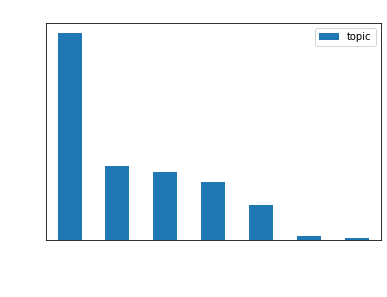

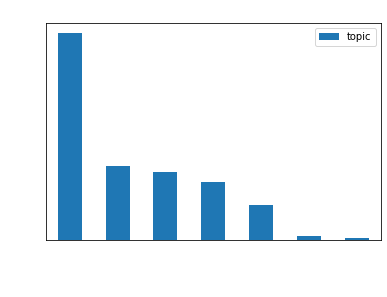

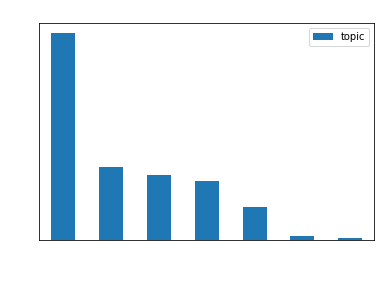

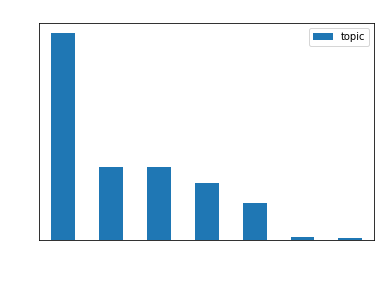

In [27]:
# (very) small EDA to check topics
for df_tmp, title in zip([df, df_train, df_valid, df_test], ["Whole set", "Train", "Valid", "Test"]):
    topic_counts = pd.DataFrame(df_tmp["topic"].value_counts()).reset_index()
    topic_counts["prop"] = topic_counts["topic"] / np.sum(topic_counts["topic"])
    display(topic_counts)
    ax = topic_counts.plot.bar(x="index", y="topic")
    ax.set_title(title)
    ax.title.set_color("white")
    ax.xaxis.label.set_color("white")
    ax.tick_params(colors="white", which="both") 

# 606 and 607 probably be an issue
# hopefully not the others

### Preprocessing

As proposed by [Zahera et al. 2019](https://trec.nist.gov/pubs/trec28/papers/DICE_UPB.IS.pdf):
- Stop-words, URLs, usernames and unicode-characters are removed.
- Extra white-spaces, repeated full stops, question marks and exclamation marks are removed.
- ~~Emojis were converted to text using the python library emoji~~
- Lemmatization, restoring language vocabulary to general form (can express complete
semantics) by WordNetLemmatizer 5 .
- Finally all tweet tokens are converted to lower-case.
  
--- 

- add tweet type?
- add authorusername?
- not remove handles?

In [140]:
en_stopwords = set(stopwords.words("english"))
tokenizer = TweetTokenizer(preserve_case=False, match_phone_numbers=False)
lemmatizer = WordNetLemmatizer()

def preprocess(txt):
    tokens = tokenizer.tokenize(txt)

    for i, token in enumerate(tokens):
        if token in en_stopwords or token in (",", "?", "!", ":", "."):
            tokens[i] = "[DEL]"
            continue
        elif token.startswith("http"):
            tokens[i] = "[URL]"
            continue
        elif token.startswith("@"):
            tokens[i] = "[HANDLE]"
            continue
        else:
            tokens[i] = lemmatizer.lemmatize(token)
            
    while True:
        try:
            tokens.remove("[DEL]")
        except ValueError:
            break
    return " ".join(tokens)



In [142]:
tw = df["text"].sample(1)
print(tw.values[0])
preprocess(tw.values[0])

# tw = "Our message to business is clear: @amor if you stand by your workers, we will stand by you. https://t.co/lWMKVlSFyz"
# preprocess(tw)

When will you meet production expectations, @AstraZeneca? People are waiting. We need a delivery schedule for Q2. 
Time is of the essence. How can we help you so that Europeans get their #vaccines?

🗣️ ECR MEP @BeataSzydlo | @EP_Industry @EP_Environment #COVID19 #AstraZeneca https://t.co/KXSz20lYXb


'meet production expectation [HANDLE] people waiting need delivery schedule q2 time essence help european get #vaccines 🗣 ️ ecr mep [HANDLE] | [HANDLE] [HANDLE] #covid19 #astrazeneca [URL]'

### Baseline (Multinomial naive bayes)

In [162]:
X_train, X_valid = df_train["text"], df_valid["text"]
y_train, y_valid = df_train["topic"], df_valid["topic"]

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(preprocessor=preprocess, tokenizer=tokenizer.tokenize)),
    ("clf", MultinomialNB())
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(preprocessor=<function preprocess at 0x7f8e61e75b80>,
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7f8e64fe3310>>)),
                ('clf', MultinomialNB())])

In [163]:
# Evaluation
y_pred = pipe.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

       601.0       0.83      0.50      0.62      1750
       602.0       0.56      0.97      0.71      4975
       603.0       0.89      0.27      0.41       797
       604.0       0.73      0.20      0.31      1417
       605.0       0.73      0.17      0.28      1579
       606.0       0.00      0.00      0.00        98
       607.0       0.00      0.00      0.00        48

    accuracy                           0.60     10664
   macro avg       0.53      0.30      0.33     10664
weighted avg       0.67      0.60      0.55     10664



/home/olivier/.virtualenvs/covid-unige/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/olivier/.virtualenvs/covid-unige/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/olivier/.virtualenvs/covid-unige/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

As expected, classes 606 and 607 are not predicted at all. The multinomial model performs worse than the naive baseline of classifying all tweets as 602 (would get ~46% accuracy). 

Also note the huge difference between precision and recall:
need to investigate why 602 tweets performs differently than the others, meaning that it has a big recall but low precision (like all the others)

### Bert

### CT-BERT
[Müller et al. 2020](https://arxiv.org/abs/2005.07503)